# Scrapping de données

On va scraper les données du site politics debate.

In [91]:
'''
Importation des differents modules et librairie pour le scrapping de données:
- Request pour faire des requetes HTTP
- BeautifulSoup pour le webscrapping et les requêtes sur les balises HTML,
- Pandas pour la transformation en dataframe, 
- Sleep et Randint sont utiliser pour contourner certaine protection de site web, par exemple, si l'on envoie trop de requêtes a un site web en trop peu de temps, il peut nous bloquer l'accès a son site,
on utilise donc la fonction sleep pour "simuler" du comportement humain.
- Numpy pour l'utilisations d'array pour ranger les pages que l'on va scrapper.
'''

import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
from time import sleep
import numpy as np
from random import randint

In [92]:
# Mise en place du header pour le  webscraping
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebkit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}

In [93]:
url = "https://debatepolitics.com/forums/2024-us-presidential-election.227/?order=reply_count&direction=desc"

response = requests.get(url)

In [94]:
if response.status_code == 200:
    # Verifier la validité de la requête 
    # Parser le contenu HTML avec BeautifulSoup
    soup = bs(response.content, 'html.parser')

    # Trouver toutes les balises <a> et extraire les valeurs href qui contiennent "/threads/"
    hrefs = [a.get('href') for a in soup.find_all('a') if a.get('href') and '/threads/' in a.get('href')]

    # Afficher la liste des href filtrées
    #print(hrefs)
else:
    print(f"Erreur lors de la requête HTTP: {response.status_code}")

In [95]:
liste_output = []
def get_good_url(liste_input):
    # On retire les 3 première lignes, car il s'agit de lien qui ne concerne pas la politique
    liste_input = liste_input[3:]
    i = 0
    while i < len(liste_input):
        # On ne récupère que la derniere page de chaque forum et on supprime les autres liens
        liste_output.append(liste_input[4])
        liste_input = liste_input[6:]     
        i=i+1 
    return liste_output

In [96]:
new_ref = get_good_url(hrefs)
new_ref

['/threads/w-1063-2024-presidential-election-night-discussion.554288/page-142',
 '/threads/live-1-oct-2024-cbs-vance-walz-vice-presidential-debate-thread.551180/page-45',
 '/threads/polling-stuff.551212/page-43',
 '/threads/its-amazing-how-an-election-loss-even-as-big-as-this-one-still-doesnt-put-a-dent-in-the-thinking-that-lost-it.555363/page-39',
 '/threads/vance-has-put-a-lot-of-thought-into-his-hatred-of-women.548706/page-33',
 '/threads/harris-agrees-to-sit-for-interview-with-fox-news.552228/page-33',
 '/threads/live-wed-16-oct-2024-6p-est-fox-news-bret-baier-interview-with-vice-president-kamala-harris-live-thread.552424/page-32',
 '/threads/trump-working-the-french-frie-station-at-mcdonalds.552764/page-31',
 '/threads/harris-is-on-track-to-lose.552236/page-31',
 '/threads/trump-desecrates-arlington-national-cemetery-in-prohibited-photo-op.548308/page-26',
 '/threads/live-cnn-harris-walz-interview-29-aug-2024.548550/page-24',
 '/threads/democrats-dont-understand-what-it-means-to-b

In [97]:
pages = [] # On stock le numéro de la page de fin
liens = [] # On stock l'url du lien  a traiter 
len_p = len('page-')
for v in new_ref:
    find_page = v.find('page-')
    tmp = v[(find_page+len_p):]
    pages.append(int(tmp))
    v = v[:v.rfind('-')+1]
    liens.append(v) # On récupère le numéro de pages et on le stock dans la liste liens
len(pages)

18

In [98]:
data_text = []
data_gender = []
data_politics = []
data_localisation = [] 
# Création de liste pour le webscrapping
nb_forums = np.arange(0,len(pages), 1)
url = 'https://debatepolitics.com/' # URL de base

# Boucle qui sert a parcourir une page parmis notre liste de pages et aller recuperer les informations qui nous interesse. ( contenu du texte, le genre, le bord politique, la localisation)
for index in nb_forums:
    page = pages[index]
    lien = liens[index]
    
    for p in range(page,1, -1): # Décrémentation pour parcourir les pages dans l'ordre inverse
        page = requests.get(url+lien+str(p))
        soup = bs(page.text, 'html.parser')
        acc_data = soup.find_all('div', class_= 'message-inner')
        #sleep(randint(2,6))
    
        for data in acc_data:
            #Récupération du genre, duu bord politique, texte et localisation
            gender = data.find('dl', {'class' : 'pairs pairs--justified', 'data-field': 'gender'})
            politics = data.find('dl', {'class' : 'pairs pairs--justified', 'data-field': 'political_leaning'})
    
            localisation = data.find('a', {'class' : 'u-concealed'})
    
            text = data.find('div', {'class' : 'bbWrapper'})
            # supprime les réponses des utilisateur pour pas avoir de doublons
            div_to_remove = text.find('div', class_ = 'bbCodeBlock-expandContent js-expandContent') 
            if div_to_remove:
                div_to_remove.decompose()
            # Début de Nettoyage du code
            if text is not None:
                if gender:
                    data_gender.append(gender.text)
                else:
                    data_gender.append(None)
                if politics:
                    data_politics.append(politics.text)
                else:
                    data_politics.append(None)
                if localisation:
                    data_localisation.append(localisation.text)
                else:
                    data_localisation.append(None)
                data_text.append(text.text)



In [99]:
#création du dictionnaire pour pouvoir ranger nos données
dico = {
    "gender": data_gender,
    "politics": data_politics,
    "localisation": data_localisation,
    "text": data_text
}

In [100]:
# Conversion de notre dictionnaire en dataframe pour le traitement des donnée
df = pd.DataFrame(dico)
len(df)

14914

In [101]:
# On travail sur une copie pour eviter la redondansce
df2 = df.copy()

In [102]:
# Exploration du dataframe
df2.head()

,gender,politics,localisation,text
0,\nGender\nMale\n,\nPolitical Leaning\nConservative\n,None,\n\nModernDiogenes said:\n\n\n\nClick to expan...
1,\nGender\nMale\n,\nPolitical Leaning\nIndependent\n,North East,\n\nOpportunityCost said:\n\n\n\nClick to expa...
2,\nGender\nMale\n,\nPolitical Leaning\nConservative\n,None,\n\nModernDiogenes said:\n\n\n\nClick to expan...
3,\nGender\nMale\n,\nPolitical Leaning\nSlightly Conservative\n,"Toronto & Amsterdam, Holland",Probably a good idea\n\nhttps://www.cnn.com/20...
4,\nGender\nMale\n,\nPolitical Leaning\nSlightly Conservative\n,"Toronto & Amsterdam, Holland",That 2020 election does start to look a little...


In [103]:
# Nettoyage de la colonnes texte
word1_truncate = 'said:\n\n\n'
word1_len = len(word1_truncate)
word2_truncate = 'Click to expand...\n\n'
word2_len = len(word2_truncate)

for index in df2.index:
    tmp = df2.at[index, 'text']
    tr1 = tmp.rfind(word1_truncate)
    if tr1 != -1:
        tmp = tmp[tr1+word1_len:]

    tr2 = tmp.rfind(word2_truncate)
    if tr2 != -1:
        tmp = tmp[tr2+word2_len:]

    tmp = tmp.lstrip('\n')
    tmp = tmp.rstrip('\n')
        
    df2.at[index,'text'] = tmp

    
#df2

In [104]:
#N Nettoyage de la colonne Gender et Political
word_truncate1 = '\nGender\n'
len_word1 = len(word_truncate1)

for index in df2.index:
    if df2.at[index, 'gender']:
        tmp = df2.at[index, 'gender']
        tmp = tmp[len_word1:]
        df2.at[index, 'gender'] = tmp


word_truncate2 = '\n'
len_word2 = len(word_truncate2)

for index in df2.index:
    if df2.at[index, 'gender']:
        tmp = df2.at[index, 'gender']
        tmp = tmp[:-1] #points de l'autre côté pour supprimer la fin
        df2.at[index, 'gender'] = tmp


word_truncate3 = '\nPolitical Leaning\n'
len_word3 = len(word_truncate3)

for index in df2.index:
    if df2.at[index, 'politics']:
        tmp = df2.at[index, 'politics']
        tmp = tmp[len_word3:]
        df2.at[index, 'politics'] = tmp


word_truncate4 = '\n'
len_word4 = len(word_truncate4)

for index in df2.index:
    if df2.at[index, 'politics']:
        tmp = df2.at[index, 'politics']
        tmp = tmp[:-1]
        df2.at[index, 'politics'] = tmp

In [105]:
# On verifie que le dataframe est nettoyer
df2.head()

,gender,politics,localisation,text
0,Male,Conservative,None,"It's really simple, no one wants to say it, do..."
1,Male,Independent,North East,"First off it is highly possible, even probable..."
2,Male,Conservative,None,LOL holy **** are you ever toting that water. ...
3,Male,Slightly Conservative,"Toronto & Amsterdam, Holland",Probably a good idea\n\nhttps://www.cnn.com/20...
4,Male,Slightly Conservative,"Toronto & Amsterdam, Holland",That 2020 election does start to look a little...


In [106]:
# Donnée nettoyer exporter en csv pour l'historisation
df2.to_csv('forums.csv', index=False)

In [107]:
# Donnée brut exporter en csv pour l'historisation
df.to_csv('donnees_brutes.csv', index=False)

In [1]:
# Nettoyage et transformation de la colonnes localisation
pd.set_option('display.max_rows', None)
# Dictionnaire pour les états US
us_states_map = {
    'AL': 'Alabama',
    'KY': 'Kentucky',
    'NC': 'North Carolina',
    'SC': 'South Carolina',
    'NY': 'New York',
    'Long Island NY': 'New York',
    'Nassau County, Long Island': 'New York',
    'Central NY': 'New York',
    'Western New York': 'New York',
    'Western New York State': 'New York',
    'New York City area': 'New York',
    'The Big Apple': 'New York',
    'Fort Drum, New York': 'New York',
    'IL—16': 'Illinois',
    'KCMO & 50K Feet Up 4Reagan4Perot4Obama': 'Missouri',
    'Springfield MO': 'Missouri',
    'The St. Louis Metro': 'Missouri',
    'Near Boise, ID': 'Idaho',
    'North Idaho': 'Idaho',
    'Houston Area, TX': 'Texas',
    'Houston, in the great state of Texas': 'Texas',
    'North Texas': 'Texas',
    'Uhland, Texas': 'Texas',
    'DFW': 'Texas',
    'Third Coast': 'Texas',
    'Tucson': 'Arizona',
    'Tucson, AZ': 'Arizona',
    'arizona': 'Arizona',
    'Sarasota Fla': 'Florida',
    'Flori-duh': 'Florida',
    'Florida The Armband State': 'Florida',
    'Tampa Bay area': 'Florida',
    'Cambridge, MA': 'Massachusetts',
    'Western Mass.': 'Massachusetts',
    'Near Seattle': 'Washington',
    'Outside Seattle': 'Washington',
    'Seattle WA': 'Washington',
    'Washington State': 'Washington',
    'SoCal': 'California',
    'Southern California': 'California',
    'The Bay': 'California',
    'SF Bay Area': 'California',
    'Los Angeles': 'California',
    'San Diego': 'California',
    'Mentor Ohio': 'Ohio',
    'NE Ohio': 'Ohio',
    'Ohio, USA': 'Ohio',
    'Columbus, OH': 'Ohio',
    'Southern OR': 'Oregon',
    'Portlandia': 'Oregon',
    'Northern Nevada': 'Nevada',
    'SW Virginia': 'Virginia',
    'Northern New Jersey': 'New Jersey',
    'New Mexico, USA': 'New Mexico',
    'Tennessee, USA': 'Tennessee',
    'Bridgeport, CT': 'Connecticut',
    'Philadelphia': 'Pennsylvania',
    'Rolesville, NC': 'North Carolina',
    'Atlanta': 'Georgia'
}

# Dictionnaire pour les régions US
us_regions_map = {
    'Blue Ridge Mountains': 'Unknown',
    'Central Texas': 'Texas',
    'Greater Boston Area': 'Massachusetts',
    'Mid-West USA': 'Unknown',
    'N. Virginia': 'Virginia',
    'Western Virginia': 'Virginia',
    'North East': 'Unknown',
    'Pacific NW': 'Unknown',
    'PNW': 'Unknown',
    'US Southwest': 'Unknown',
    'PDX and ATL': 'Unknown',
    'New England, United States': 'Unknown'
}

# Dictionnaire pour les autres pays
countries_map = {
    'Best Coast Canada': 'Canada',
    'Lower Mainland of BC': 'Canada',
    'Vancouver, Canada Dual citizen': 'Canada',
    'North norfolk England': 'UK',
    'North norfolk  England': 'UK',
    'Southern England': 'UK',
    'Devonshire, England': 'UK',
    'Suierland, Germany': 'Germany',
    'Paris, France': 'France',
    'Tijuana, B.C., Mexico.': 'Mexico',
    '🇦🇹 Austria 🇦🇹': 'Austria',
    'U.S.': 'USA',
    'US': 'USA',
    'USofA': 'USA',
    'United States': 'USA',
    'United States, all over.': 'USA',
    'US of A': 'USA',
    'America, the place that has ALWAYS been great': 'USA'
}

def standardize_location(location):
    """
    Standardise une localisation en utilisant les dictionnaires de mapping.
    Si la localisation n'est pas trouvée ou est vide/NaN, renvoie 'Unknown'.
    """
    import pandas as pd
    
    # Gestion des valeurs NaN et vides
    if pd.isna(location) or not str(location).strip():
        return 'Unknown'
    
    # Conversion en string pour être sûr
    location = str(location)
        
    # Vérifier dans l'ordre: états US, régions US, pays
    for mapping in [us_states_map, us_regions_map, countries_map]:
        if location in mapping:
            return mapping[location]
            
    return 'Unknown'

# Nettoyage de la colonne localisation
df2['localisation'] = df['localisation'].apply(standardize_location)
df2.head()


NameError: name 'pd' is not defined

In [109]:
# Ajout de colonnes indicative pour les mots cléf liée à l'éléction
df2['id'] = 0
df2['Trump'] = False
df2['Kamala'] = False
df2['Democrat'] = False
df2['Republican'] = False

for index in df2.index:
    df2.at[index, 'id'] = tmp = index
    if 'trump' in df2.at[index,'text'].lower():
        df2.at[index, 'Trump'] = True
    if 'kamala' in df2.at[index,'text'].lower():
        df2.at[index, 'Kamala'] = True
    if 'democrat' in df2.at[index,'text'].lower():
        df2.at[index, 'Democrat'] = True
    if 'republic' in df2.at[index,'text'].lower():
        df2.at[index, 'Republican'] = True
df2.head()

,gender,politics,localisation,text,id,Trump,Kamala,Democrat,Republican
0,Male,Conservative,Unknown,"It's really simple, no one wants to say it, do...",0,True,False,False,False
1,Male,Independent,Unknown,"First off it is highly possible, even probable...",1,False,False,False,False
2,Male,Conservative,Unknown,LOL holy **** are you ever toting that water. ...,2,False,False,False,False
3,Male,Slightly Conservative,Unknown,Probably a good idea\n\nhttps://www.cnn.com/20...,3,True,False,False,False
4,Male,Slightly Conservative,Unknown,That 2020 election does start to look a little...,4,False,True,True,False


In [110]:
# Exportation du dataframe finale apres nettoyage, pret pour le preprocessing
chemin = "../Code/data_pour_modele.csv"
df2.to_csv(chemin, index=False)

# Analyse du dataFrame récolté pendant la phase de webscrapping et nettoyer pendant la phase de preprocessing

## Installation des differents modules

- pandas, numpy, matplotlib, seaborn, plotly sont des incourtournables de la data science et sont utilisé dans presque tout les notebooks
- string, nltk, wordcloud sont ici importer car on va faire du traitement de texte 

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
import plotly.express as px

import string
import re
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud
import nltk

# Télécharger les ressources nécessaires pour NER
nltk.download('averaged_perceptron_tagger') 
nltk.download('maxent_ne_chunker')  
nltk.download('words')  
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antoinetheissen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/antoinetheissen/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/antoinetheissen/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/antoinetheissen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/antoinetheissen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinetheissen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploration du dataFrame obtenu par la partie preprocessing

In [115]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14914 entries, 0 to 14913
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gender        14271 non-null  object
 1   politics      14194 non-null  object
 2   localisation  14914 non-null  object
 3   text          14914 non-null  object
 4   id            14914 non-null  int64 
 5   Trump         14914 non-null  bool  
 6   Kamala        14914 non-null  bool  
 7   Democrat      14914 non-null  bool  
 8   Republican    14914 non-null  bool  
dtypes: bool(4), int64(1), object(4)
memory usage: 641.0+ KB


In [141]:
df2.head(15)

,gender,politics,localisation,text,id,Trump,Kamala,Democrat,Republican
0,Male,Conservative,Unknown,"It's really simple, no one wants to say it, do...",0,True,False,False,False
1,Male,Independent,Unknown,"First off it is highly possible, even probable...",1,False,False,False,False
2,Male,Conservative,Unknown,LOL holy **** are you ever toting that water. ...,2,False,False,False,False
3,Male,Slightly Conservative,Unknown,Probably a good idea\n\nhttps://www.cnn.com/20...,3,True,False,False,False
4,Male,Slightly Conservative,Unknown,That 2020 election does start to look a little...,4,False,True,True,False
5,Male,Moderate,Unknown,"Out of the seven battleground states, Harris r...",5,False,False,False,False
6,Male,Independent,Unknown,"It was 33,000 e mails and they were ALL the sa...",6,False,False,False,False
7,Male,Conservative,Unknown,See this is where your ethics go to shit again...,7,False,False,False,False
8,Male,Independent,Unknown,You see this is where your reading comprehensi...,8,True,False,False,False
9,Female,Independent,New York,Spot on !!! Wow - truth !,9,False,False,False,False


# NLTK

Ici on commence par un exemple educatif de comment fonctionne l'analyse de sentiments avec NLTK et notemment avec SentimentAnalyzer, on va prendre la ligne 45 et la tokenizer par 2 process differents avant de lui faire passer dans le SentimentAnalyzer

### Zone de test libre 

Ici on a pu tester differentes phrases pour voir a quel point la fonction est précise, ( on écris en anglais car le modèle est fait pour reconnaitre l'anglais)

In [118]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [119]:
texte = "I think trump is a fool"
sia.polarity_scores(texte)

{'neg': 0.492, 'neu': 0.508, 'pos': 0.0, 'compound': -0.4404}

In [120]:
df2.head()

,gender,politics,localisation,text,id,Trump,Kamala,Democrat,Republican
0,Male,Conservative,Unknown,"It's really simple, no one wants to say it, do...",0,True,False,False,False
1,Male,Independent,Unknown,"First off it is highly possible, even probable...",1,False,False,False,False
2,Male,Conservative,Unknown,LOL holy **** are you ever toting that water. ...,2,False,False,False,False
3,Male,Slightly Conservative,Unknown,Probably a good idea\n\nhttps://www.cnn.com/20...,3,True,False,False,False
4,Male,Slightly Conservative,Unknown,That 2020 election does start to look a little...,4,False,True,True,False


### Création de la boucle

Ici on crée une boucle qui va boucler sur le texte, et qui va garder l'id en paramètre car ce sera utile pour le merge juste après. On lance le test sur chaque texte du dataframe, et on stock les valeurs, negative, positive, neutre dans un dataframe temporaire avant de merge les deux dataframes

In [121]:
res = {}
for i, row in tqdm(df2.iterrows(), total=len(df2)):
    text = row['text']
    myid = row['id']
    
    # Vérifier si 'text' est une chaîne de caractères ou le convertir en chaîne
    if isinstance(text, str):  # Si le texte est déjà une chaîne
        res[myid] = sia.polarity_scores(text)
    else:
        # Si le texte est de type 'float' (par exemple NaN ou nombre), on le convertit en chaîne vide
        res[myid] = sia.polarity_scores(str(text))  # Convertir en chaîne avant d'utiliser

  0%|          | 0/14914 [00:00<?, ?it/s]

In [122]:
# Utilisation de vaders pour les commentaires
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})

In [123]:
print(vaders.columns)
print(df.columns)

Index(['Id', 'neg', 'neu', 'pos', 'compound'], dtype='object')
Index(['gender', 'politics', 'localisation', 'text'], dtype='object')


In [124]:
# Jointure entre nos DataFrame pour pouvoir faire des graphiques et avoir des infos
vaders = vaders.merge(df2, how='left', left_on='Id', right_on='id')

In [125]:
vaders.info(
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14914 entries, 0 to 14913
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            14914 non-null  int64  
 1   neg           14914 non-null  float64
 2   neu           14914 non-null  float64
 3   pos           14914 non-null  float64
 4   compound      14914 non-null  float64
 5   gender        14271 non-null  object 
 6   politics      14194 non-null  object 
 7   localisation  14914 non-null  object 
 8   text          14914 non-null  object 
 9   id            14914 non-null  int64  
 10  Trump         14914 non-null  bool   
 11  Kamala        14914 non-null  bool   
 12  Democrat      14914 non-null  bool   
 13  Republican    14914 non-null  bool   
dtypes: bool(4), float64(4), int64(2), object(4)
memory usage: 1.2+ MB


### Verifier nos resultats

Ici on utilise seaborn pour afficher  nos valeurs obtenue avec le SentimentAnalyzer

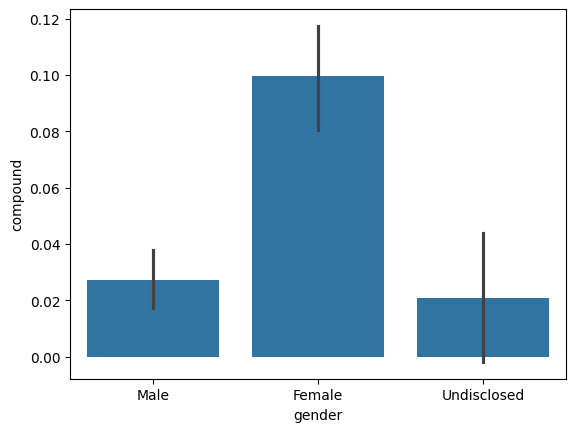

In [126]:
ax = sns.barplot(data=vaders, x='gender', y='compound')
ax.set_title('')
plt.show()

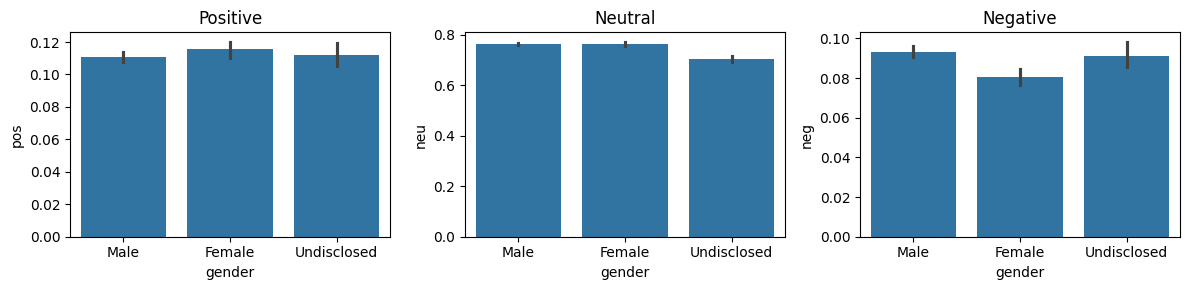

In [127]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='gender', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='gender', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='gender', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Nouveau Model de classification

Suite a une recommendation d'un ami en etude de Data Science, il ma parler du modele Roberta, un modèle qui se base sur un très grand corpus de donnée et ma permis de travailler avec, on installe alors transformers et scipy pour cette classification

In [145]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [146]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def polarity_scores_roberta_debog(example):
    try:
        # Tokenization
        encoded_text = tokenizer(example, return_tensors='pt')

        # Model prediction
        output = model(**encoded_text)

        # Extracting and processing scores
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        scores_dict = {
            'roberta_neg': scores[0],
            'roberta_neu': scores[1],
            'roberta_pos': scores[2]
        }
        return scores_dict

    except IndexError as e:
        return {'roberta_neg': None, 'roberta_neu': None, 'roberta_pos': None}


In [148]:
# Travail sur une copie pour assurer de l'historisation
roberta = df2.copy()
len(roberta)

14914

In [149]:
res = {}
for i, row in tqdm(roberta.iterrows(), total=len(roberta)):
    try:
        text = row['text']
        myid = row['id']
        roberta_result = polarity_scores_roberta_debog(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/14914 [00:00<?, ?it/s]

Broke for id 259
Broke for id 371
Broke for id 663
Broke for id 1013
Broke for id 1172
Broke for id 1386
Broke for id 1544
Broke for id 3269
Broke for id 3525
Broke for id 3574
Broke for id 3660
Broke for id 3729
Broke for id 3970
Broke for id 4698
Broke for id 5107
Broke for id 5623
Broke for id 5664
Broke for id 5677
Broke for id 5754
Broke for id 5787
Broke for id 5895
Broke for id 5974
Broke for id 6038
Broke for id 6144
Broke for id 6184
Broke for id 6933
Broke for id 7482
Broke for id 7938
Broke for id 8507
Broke for id 10254
Broke for id 10359
Broke for id 10360
Broke for id 10447
Broke for id 10623
Broke for id 10666
Broke for id 10667
Broke for id 11583
Broke for id 12208
Broke for id 12263
Broke for id 12297
Broke for id 13492
Broke for id 13720
Broke for id 13757
Broke for id 13759
Broke for id 14611
Broke for id 14613
Broke for id 14724
Broke for id 14844


In [150]:
# On supprime la ligne 599 qui est la seule ligne avec un IndexError
df_copy_2 = df2.drop(index=599)

In [159]:
#Transformation de notre dataset en dataframe
roserta_result = pd.DataFrame(res).T
roseta_output = roserta_result.reset_index().rename(columns={'index': 'Id'})
results_df = roserta_result.reset_index().rename(columns={'index': 'Id'})
roseta_output.head()

,Id,roberta_neg,roberta_neu,roberta_pos
0,0,0.508171,0.456303,0.035526
1,1,0.738458,0.238212,0.02333
2,2,0.629271,0.335142,0.035587
3,3,0.046511,0.464843,0.488646
4,4,0.90204,0.091743,0.006216


In [153]:
# Jointure entre le dataframe de resultats avec NLTK et Roberta
results_df = results_df.merge(vaders, how='left', left_on='Id', right_on='id')
results_df.columns

KeyError: 'Id'

# Comparaison entre les modèles

En ne se concentrant que sur les graphiques diagonales, on peut comparer les resultat negatif, neutre et positif entre les deux modèles, la flagrantes differences viens du fait que dans les resultat NLTK, on une meme "quantité" entre les resultat positif et negatif, tandis que avec Roserta on a plus de negatif que de positif.

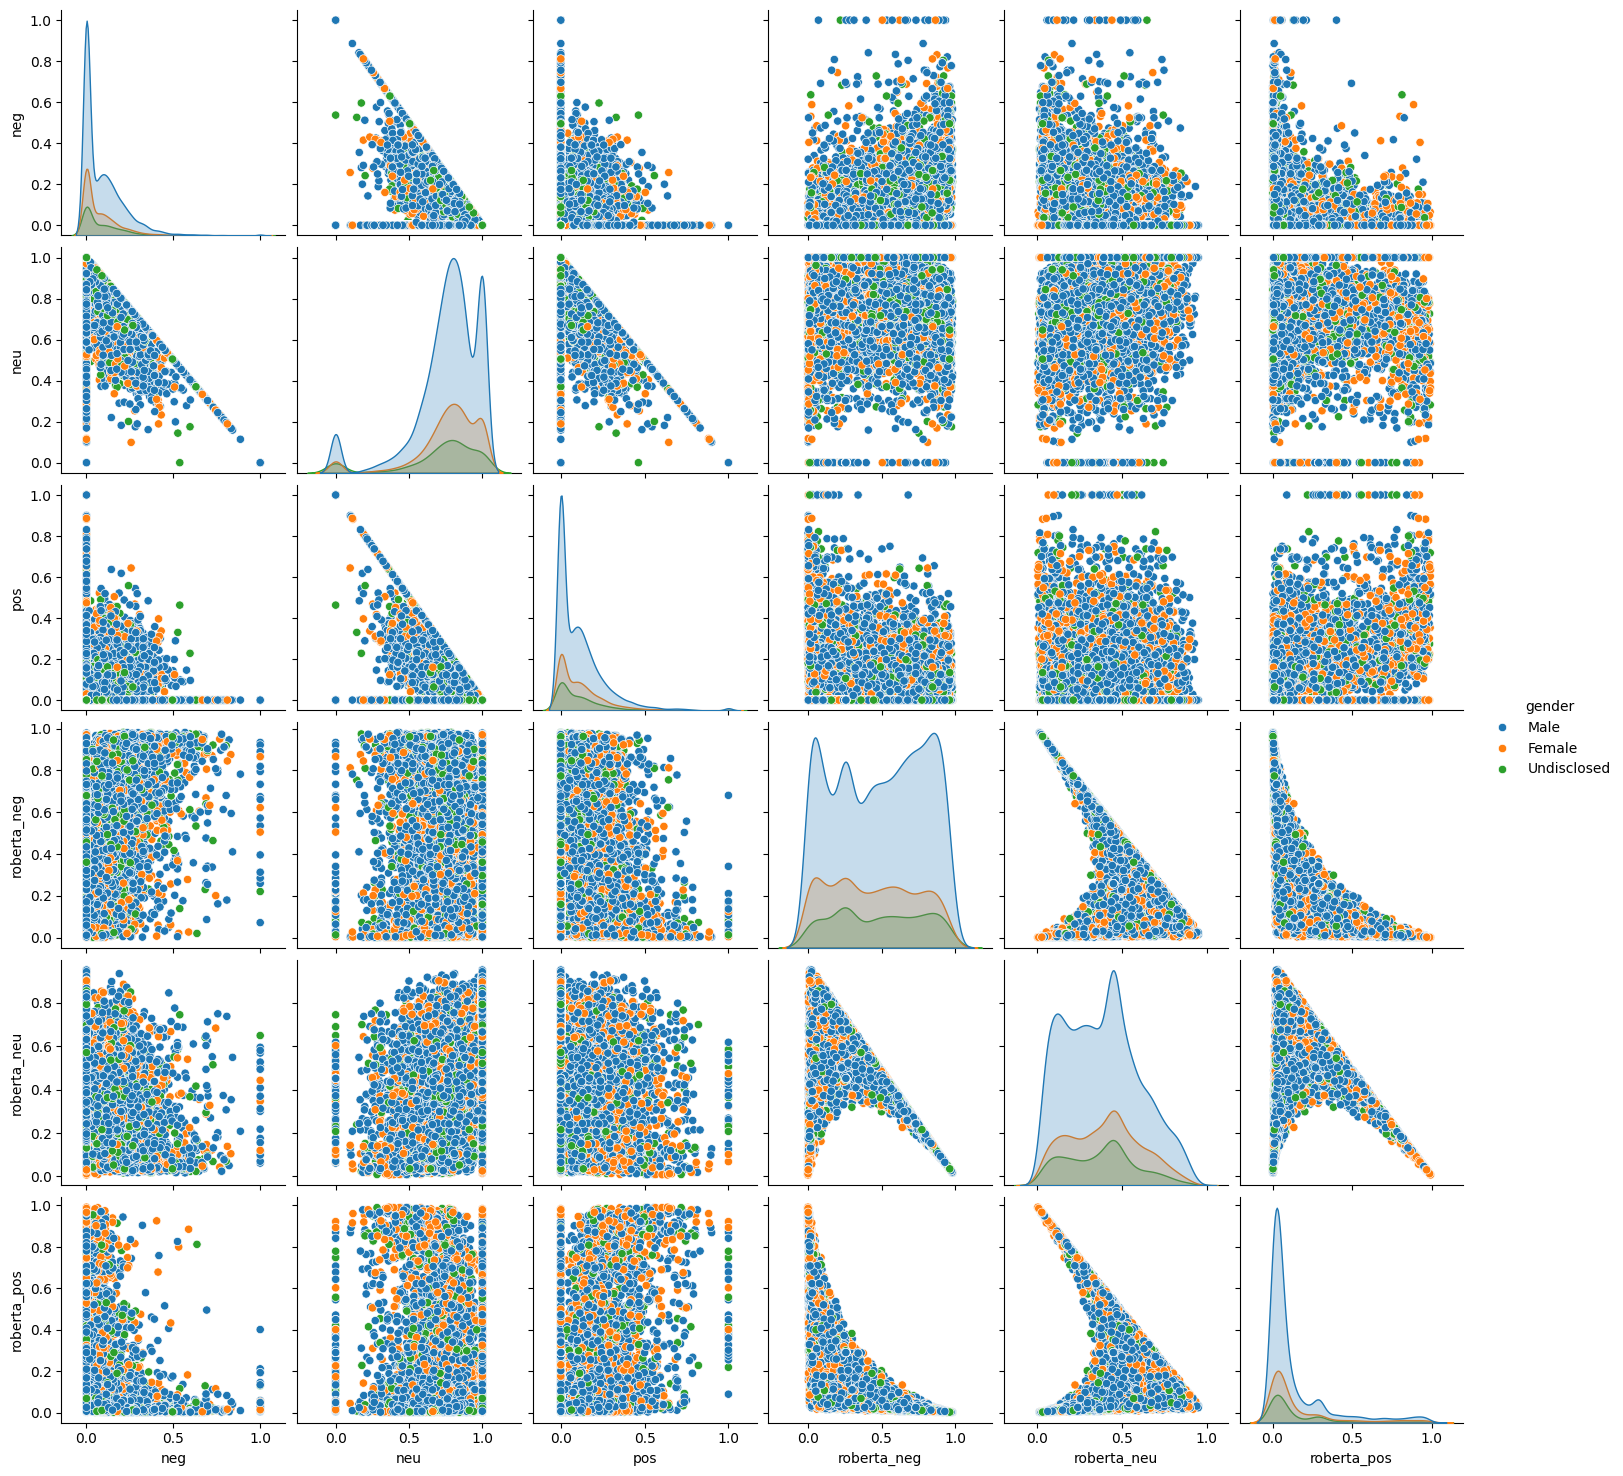

In [154]:
sns.pairplot(data=results_df,
             vars=['neg', 'neu', 'pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='gender',
            palette='tab10')
plt.show()

# Exportation en csv pour powerBi


Ici on veux continuer la visulation avec des dashboard et donc on va rendre nos resultat et crée des fichiers csv prêt a l'emploi et a passer dans les graphiques

In [139]:
nltk = "../Code/nltk_result.csv"
vaders.to_csv(nltk, index=False)
rosa = "../Code/rosa_result.csv"
roserta_output.to_csv(rosa, index=True)
commun = "../Code/commun_result.csv"
results_df.to_csv(commun, index=True)

NameError: name 'roserta_output' is not defined

In [157]:
results_df.head()



,Id_x,roberta_neg,roberta_neu,roberta_pos,Id_y,neg,neu,pos,compound,gender,politics,localisation,text,id,Trump,Kamala,Democrat,Republican
0,0,0.508171,0.456303,0.035526,0,0.084,0.840,0.076,-0.1115,Male,Conservative,Unknown,"It's really simple, no one wants to say it, do...",0,True,False,False,False
1,1,0.738458,0.238212,0.02333,1,0.028,0.972,0.000,-0.1027,Male,Independent,Unknown,"First off it is highly possible, even probable...",1,False,False,False,False
2,2,0.629271,0.335142,0.035587,2,0.041,0.842,0.117,0.6166,Male,Conservative,Unknown,LOL holy **** are you ever toting that water. ...,2,False,False,False,False
3,3,0.046511,0.464843,0.488646,3,0.000,0.508,0.492,0.4404,Male,Slightly Conservative,Unknown,Probably a good idea\n\nhttps://www.cnn.com/20...,3,True,False,False,False
4,4,0.90204,0.091743,0.006216,4,0.161,0.839,0.000,-0.8316,Male,Slightly Conservative,Unknown,That 2020 election does start to look a little...,4,False,True,True,False
